# Analyzing air quality data

"Responsible for an estimated 3.4 million deaths annually, outdoor air pollution is perhaps the world’s deadliest environmental problem. At the same time, it’s the most widespread. It affects everyone, regardless of geography or social status. In the United States alone, air pollution accounts foraround 200,000 premature deaths a year. That's sixtimes the number of people killed in car accidents." <br>
Source: http://visuals.datadriven.yale.edu/infographics/

What can we do to better understand air pollution? <br> 
There are several air pollutants - Ozone, Particulate Matter, Persistent Organic pollutants, Mercury etc<br>
Here we will look at Particulate Matter. <br>

Particulate matter, or PM, is the term for particles found in the air, including dust, dirt, soot, smoke, and liquid droplets. Particles can be suspended in the air for long periods of time. Some particles are large or dark enough to be seen as soot or smoke. Others are so small that individually they can only be detected with an electron microscope.<br>

Many manmade and natural sources emit PM directly or emit other pollutants that react in the atmosphere to form PM. These solid and liquid particles come in a wide range of sizes.<br>

Particles less than 10 micrometers in diameter (PM10) pose a health concern because they can be inhaled into and accumulate in the respiratory system. Particles less than 2.5 micrometers in diameter (PM2.5) are referred to as "fine" particles and are believed to pose the greatest health risks. Because of their small size (approximately 1/30th the average width of a human hair), fine particles can lodge deeply into the lungs. <br>
Source: https://www3.epa.gov/pmdesignations/faq.htm#0 <br>

# Analyzing data using Riak TS

In [237]:
import riak, time, csv
from datetime import datetime
import calendar

<b>Connect to Riak using Riak Python Client</b>

In [238]:
host='127.0.0.1'
pb_port = '8087'
hostAndPort = ":".join([host, pb_port])

client = riak.RiakClient(host=host, pb_port=pb_port)

<b>Create a table to store Air Quality Data</b><br>
Data for 1Q 2016 for San Francisco is fetched from epa.gov https://www3.epa.gov/airdata/ad_data.html

In [239]:
table_name_sf = 'aq1q2016-sf-%d' % int(time.time())
#print (table_name)
table = client.table(table_name_sf)

create_sql = """CREATE TABLE %(table_name)s (
measurementDate timestamp not null,
pm25mean double, 
aqi sint64,
temperatire double,
PRIMARY KEY ((quantum(measurementDate, 365, d)),
    measurementDate))
""" % ({'table_name': table_name_sf})

#print (create_sql)

result = table.query(create_sql)

<b>Check if the table is created as expected</b>

In [240]:
schema = table.describe().rows

for r in schema:
    print (r)

['measurementDate', 'timestamp', False, 1, 1]
['pm25mean', 'double', True, None, None]
['aqi', 'sint64', True, None, None]
['temperatire', 'double', True, None, None]


<b>Load the data into the table</b><br>
Data has been downloaded from the epa site and stored in a csv file in the data directory. The csv file is read and loaded into Riak TS in batches of 100 rows. Batching data gives better write performance than storing rows one at a time.

In [241]:
def loaddata_sf(filename):
    #to load data in the table
    totalcount=0
    batchcount=0
    batchsize=100
    ds=[]

    with open(filename, 'r') as infile:
        r=csv.reader(infile)
        next(r)
        for l in r:
                #print(l)
                newl=[datetime.strptime(l[0],"%m/%d/%y"),float(l[3]),int(l[5]), float(l[20])]
                
                #print(newl)
                totalcount=totalcount+1
                #print count
                ds.append(newl)
                batchcount=batchcount+1
                if batchcount==batchsize:
                    #add the records to the table
                    print ("Count at  ", totalcount)
                    to=table.new(ds)
                    print ("Created ts object")
                    print ("Storage result:  ",to.store())
                    batchcount=0
                    ds=[]   
        if len(ds)>0:
            print ("Count at  ", totalcount)
            to=table.new(ds)
            print ("Created ts object")
            print ("Storage result:  ",to.store())
            batchcount=0 
            ds=[]
    infile.close()

In [242]:
loaddata_sf('data/SF_1Q2016_AQ_data.csv')

Count at   91
Created ts object
Storage result:   True


<b>Query the data</b><br>
Determine how many bad air quality days we have had in San Francisco and how severe these have been in the first quarter of 2016. The AQI scale and impacts of various levels are as follows (Source: https://aqicn.org/calculator/)
<img src="files/data/AQIScale.png">
<img src="files/data/AQIScaleInfo.png">

In [243]:
def changetime(stime):
            dt=datetime.strptime(stime,'%Y-%m-%dT%H:%M:%S')
            #print dt
            return calendar.timegm(datetime.timetuple(dt))*1000

In [244]:
startdate=changetime('2016-01-01T00:00:00')
enddate=changetime('2016-03-31T23:59:59')

#print (startdate, enddate)

In [245]:
q="""
    select * from {table_name} where measurementDate > {t1} and measurementDate < {t2} and aqi> 50
"""
query=q.format(table_name=table_name_sf, t1=startdate, t2=enddate)
#print (query)
ds=client.ts_query(table_name_sf, query)

print (ds.rows)

[[datetime.datetime(2016, 1, 2, 0, 0), 13.2, 53, 47.5], [datetime.datetime(2016, 1, 3, 0, 0), 19.6, 67, 48.5], [datetime.datetime(2016, 1, 4, 0, 0), 17.1, 62, 52.5], [datetime.datetime(2016, 1, 8, 0, 0), 13.9, 55, 46.5], [datetime.datetime(2016, 1, 11, 0, 0), 14.0, 55, 53.0], [datetime.datetime(2016, 1, 12, 0, 0), 14.2, 55, 54.0], [datetime.datetime(2016, 1, 26, 0, 0), 12.3, 51, 51.5], [datetime.datetime(2016, 1, 27, 0, 0), 12.4, 52, 55.0], [datetime.datetime(2016, 1, 28, 0, 0), 15.8, 59, 53.0], [datetime.datetime(2016, 2, 5, 0, 0), 12.5, 52, 52.0], [datetime.datetime(2016, 2, 6, 0, 0), 12.5, 52, 54.0], [datetime.datetime(2016, 2, 9, 0, 0), 19.3, 66, 60.0], [datetime.datetime(2016, 2, 10, 0, 0), 16.5, 60, 58.5], [datetime.datetime(2016, 2, 11, 0, 0), 14.5, 56, 57.5], [datetime.datetime(2016, 2, 16, 0, 0), 17.0, 61, 63.5], [datetime.datetime(2016, 2, 24, 0, 0), 12.5, 52, 57.5], [datetime.datetime(2016, 2, 25, 0, 0), 17.5, 62, 58.5]]


<b>How many days of not so ideal days of air quality have we had in the first quarter of this year in San Francisco?</b>

In [246]:
q="""
    select count(*), max(aqi) from {table_name} where measurementDate > {t1} and measurementDate < {t2} and aqi> 50
"""
query=q.format(table_name=table_name_sf, t1=startdate, t2=enddate)
#print (query)
ds=client.ts_query(table_name_sf, query)

print (ds.rows)

[[17, 67]]


<b> Visualizing the data using pandas and matplotlib </b>

In [247]:
import pandas as pd
import numpy as np

In [248]:
q="""
    select * from {table_name} where measurementDate > {t1} and measurementDate < {t2}
"""
query=q.format(table_name=table_name_sf, t1=startdate, t2=enddate)
#print (query)
ds=client.ts_query(table_name_sf, query)

df=pd.DataFrame(ds.rows)
print (df.head())
print (df.describe())


           0     1   2     3
0 2016-01-02  13.2  53  47.5
1 2016-01-03  19.6  67  48.5
2 2016-01-04  17.1  62  52.5
3 2016-01-05   6.5  27  52.5
4 2016-01-06   4.6  19  51.5
              1          2          3
count  90.00000  90.000000  90.000000
mean    8.29000  33.588889  55.905556
std     4.13402  15.129326   3.826207
min    -0.40000   0.000000  46.500000
25%     5.27500  22.250000  53.000000
50%     7.80000  32.500000  56.000000
75%    10.57500  44.000000  58.500000
max    19.60000  67.000000  64.000000


In [249]:
#import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
%matplotlib inline

In [250]:
aq1q2016 = np.array(df)
aq1q2016.shape

(90, 4)

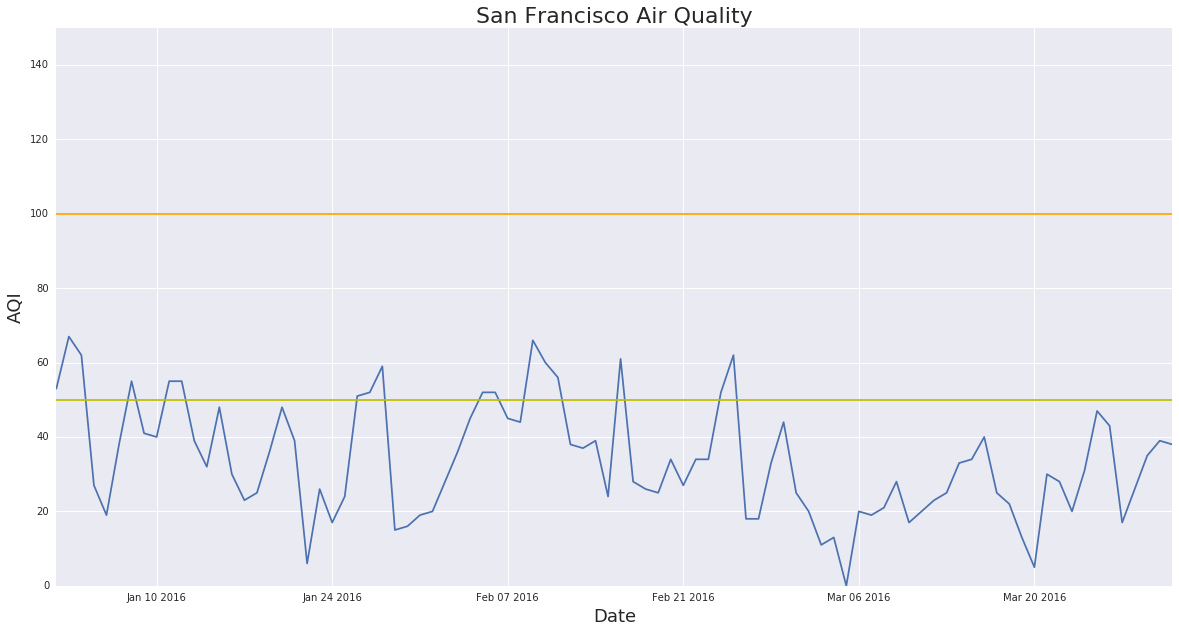

In [251]:
plt.figure(figsize=(20,10))
plt.plot(aq1q2016[:,0], aq1q2016[:,2])
plt.title("San Francisco Air Quality", fontsize=22)
plt.xlabel('Date', fontsize=18)
plt.ylabel('AQI', fontsize=18)
plt.ylim((0,150))
plt.axhline(y=50, label='Moderate', color='y')
plt.axhline(y=100, label='Unhealthy for sensitive groups', color='#FFA500')

<b>Lets see what Air Quality looks like for the same time frame in China</b>

Data for China Air Quality was obtained from The U.S. Department of State Mission
China air quality monitoring program. Data use statement can be found here http://www.stateair.net/web/assets/USDOS_AQDataUseStatement.pdf <br><br>
Create a table to store the data

In [252]:
table_name_bj = 'aq1q2016-bj-%d' % int(time.time())
#print (table_name)
table = client.table(table_name_bj)

In [253]:
create_sql = """CREATE TABLE %(table_name)s (

measurementDate timestamp not null,
pm25 sint64, 
PRIMARY KEY ((quantum(measurementDate, 30, d)),
    measurementDate))
""" % ({'table_name': table_name_bj})

print (create_sql)

result = table.query(create_sql)

CREATE TABLE aq1q2016-bj-1463602231 (

measurementDate timestamp not null,
pm25 sint64, 
PRIMARY KEY ((quantum(measurementDate, 30, d)),
    measurementDate))



In [254]:
schema = table.describe().rows

for r in schema:
    print (r)

['measurementDate', 'timestamp', False, 1, 1]
['pm25', 'sint64', True, None, None]


<b>Load data in the table</b><br> Since the data is available in different formats, need to parse it differently. 

In [255]:
def loaddata_bj(filename):
    #to load data in the table
    totalcount=0
    batchcount=0
    batchsize=100
    ds=[]

    with open(filename, 'r') as infile:
        r=csv.reader(infile)
        next(r)
        for l in r:
                newl=[datetime.strptime(l[0],"%m/%d/%y %H:%M"),int(l[1])]
                totalcount=totalcount+1
                #print count
                ds.append(newl)
                batchcount=batchcount+1
                if batchcount==batchsize:
                    #add the records to the table
                    print ("Count at  ", totalcount)
                    to=table.new(ds)
                    print ("Created ts object")
                    print ("Storage result:  ",to.store())
                    batchcount=0
                    ds=[]   
        if len(ds)>0:
            print ("Count at  ", totalcount)
            to=table.new(ds)
            print ("Created ts object")
            print ("Storage result:  ",to.store())
            batchcount=0 
            ds=[]
    infile.close()

In [256]:
loaddata_bj('data/Beijing_1Q2016_AQ_data_sub.csv')

Count at   100
Created ts object
Storage result:   True
Count at   200
Created ts object
Storage result:   True
Count at   300
Created ts object
Storage result:   True
Count at   400
Created ts object
Storage result:   True
Count at   500
Created ts object
Storage result:   True
Count at   600
Created ts object
Storage result:   True
Count at   700
Created ts object
Storage result:   True
Count at   800
Created ts object
Storage result:   True
Count at   900
Created ts object
Storage result:   True
Count at   1000
Created ts object
Storage result:   True
Count at   1100
Created ts object
Storage result:   True
Count at   1200
Created ts object
Storage result:   True
Count at   1300
Created ts object
Storage result:   True
Count at   1400
Created ts object
Storage result:   True
Count at   1500
Created ts object
Storage result:   True
Count at   1600
Created ts object
Storage result:   True
Count at   1700
Created ts object
Storage result:   True
Count at   1800
Created ts object
Storag

<b>Query the data to determine what Air Quality looked like in Beijing in 1Q2016<b>

In [257]:
q="""
    select * from {table_name} where measurementDate > {t1} and measurementDate < {t2} and pm25> 50
"""
query=q.format(table_name=table_name_bj, t1=startdate, t2=enddate)
#print (query)
ds=client.ts_query(table_name_bj, query)

print (ds.rows)

[[datetime.datetime(2016, 1, 1, 1, 0), 239], [datetime.datetime(2016, 1, 1, 2, 0), 205], [datetime.datetime(2016, 1, 1, 3, 0), 167], [datetime.datetime(2016, 1, 1, 4, 0), 132], [datetime.datetime(2016, 1, 1, 5, 0), 169], [datetime.datetime(2016, 1, 1, 6, 0), 162], [datetime.datetime(2016, 1, 1, 7, 0), 123], [datetime.datetime(2016, 1, 1, 8, 0), 100], [datetime.datetime(2016, 1, 1, 9, 0), 101], [datetime.datetime(2016, 1, 1, 10, 0), 111], [datetime.datetime(2016, 1, 1, 11, 0), 115], [datetime.datetime(2016, 1, 1, 12, 0), 135], [datetime.datetime(2016, 1, 1, 13, 0), 165], [datetime.datetime(2016, 1, 1, 14, 0), 176], [datetime.datetime(2016, 1, 1, 15, 0), 187], [datetime.datetime(2016, 1, 1, 16, 0), 207], [datetime.datetime(2016, 1, 1, 17, 0), 235], [datetime.datetime(2016, 1, 1, 18, 0), 268], [datetime.datetime(2016, 1, 1, 19, 0), 302], [datetime.datetime(2016, 1, 1, 20, 0), 330], [datetime.datetime(2016, 1, 1, 21, 0), 345], [datetime.datetime(2016, 1, 1, 22, 0), 375], [datetime.datetime

In [258]:
q="""
    select count(*) from {table_name} where measurementDate > {t1} and measurementDate < {t2} and pm25> 50
"""
query=q.format(table_name=table_name_bj, t1=startdate, t2=enddate)
#print (query)
ds=client.ts_query(table_name_bj, query)

print (ds.rows)

[[897]]


<b>Visualize the data</b>

In [259]:
q="""
    select * from {table_name} where measurementDate > {t1} and measurementDate < {t2}
"""
query=q.format(table_name=table_name_bj, t1=startdate, t2=enddate)
#print (query)
ds=client.ts_query(table_name_bj, query)

df=pd.DataFrame(ds.rows)
print (df.head())
print (df.describe())


                    0    1
0 2016-01-01 01:00:00  239
1 2016-01-01 02:00:00  205
2 2016-01-01 03:00:00  167
3 2016-01-01 04:00:00  132
4 2016-01-01 05:00:00  169
                 1
count  2182.000000
mean     67.360678
std     102.420807
min    -999.000000
25%      12.000000
50%      30.000000
75%     102.000000
max     601.000000


In [260]:
aq1q2016 = np.array(df)
aq1q2016.shape

(2182, 2)

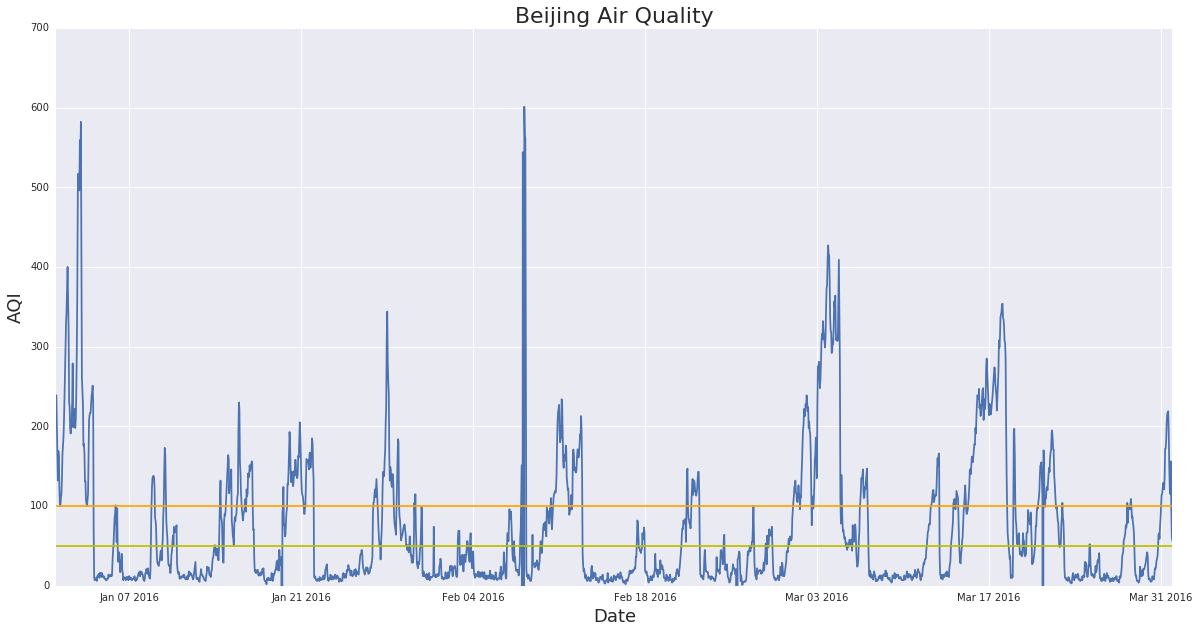

In [261]:
plt.figure(figsize=(20,10))
plt.plot(aq1q2016[:,0], aq1q2016[:,1])
plt.title("Beijing Air Quality", fontsize=22)
plt.xlabel('Date', fontsize=18)
plt.ylabel('AQI', fontsize=18)
plt.ylim((0,700))
plt.axhline(y=50, label='Moderate', color='y')
plt.axhline(y=100, label='Unhealthy for sensitive groups', color='#FFA500')

<b>What influences PM? </b><br>
PM polution is generally worse in cold winter months when particulates are trapped between warm and cool layer of air in the atmosphere.<br>
So lets look at 2015 SF data and see if there is a correlation between PM2.5 and Temperature<br>
Temperature data was obtained from http://w2.weather.gov/climate/xmacis.php?wfo=mtr

In [262]:
table = client.table(table_name_sf)
loaddata_sf('data/SF_2015_AQ_data.csv')

Count at   100
Created ts object
Storage result:   True
Count at   200
Created ts object
Storage result:   True
Count at   300
Created ts object
Storage result:   True
Count at   365
Created ts object
Storage result:   True


In [263]:
startdate=changetime('2015-01-01T00:00:00')
enddate=changetime('2015-12-31T23:59:59')
q="""
    select * from {table_name} where measurementDate > {t1} and measurementDate < {t2}
"""
query=q.format(table_name=table_name_sf, t1=startdate, t2=enddate)
#print (query)
ds=client.ts_query(table_name_sf, query)

df=pd.DataFrame(ds.rows)
print (df.head())
print (df.describe())


           0     1   2     3
0 2015-01-02  22.6  73  45.0
1 2015-01-03  27.9  84  46.0
2 2015-01-04  28.8  86  48.0
3 2015-01-05  20.6  69  51.0
4 2015-01-06  30.5  90  52.0
                1           2           3
count  364.000000  364.000000  364.000000
mean   -14.564011    7.302198   60.456044
std    147.905391  152.387887    6.436765
min   -999.000000 -999.000000   41.000000
25%      3.500000   15.000000   56.500000
50%      6.200000   26.000000   60.000000
75%     10.000000   42.000000   65.500000
max     35.400000  100.000000   78.500000


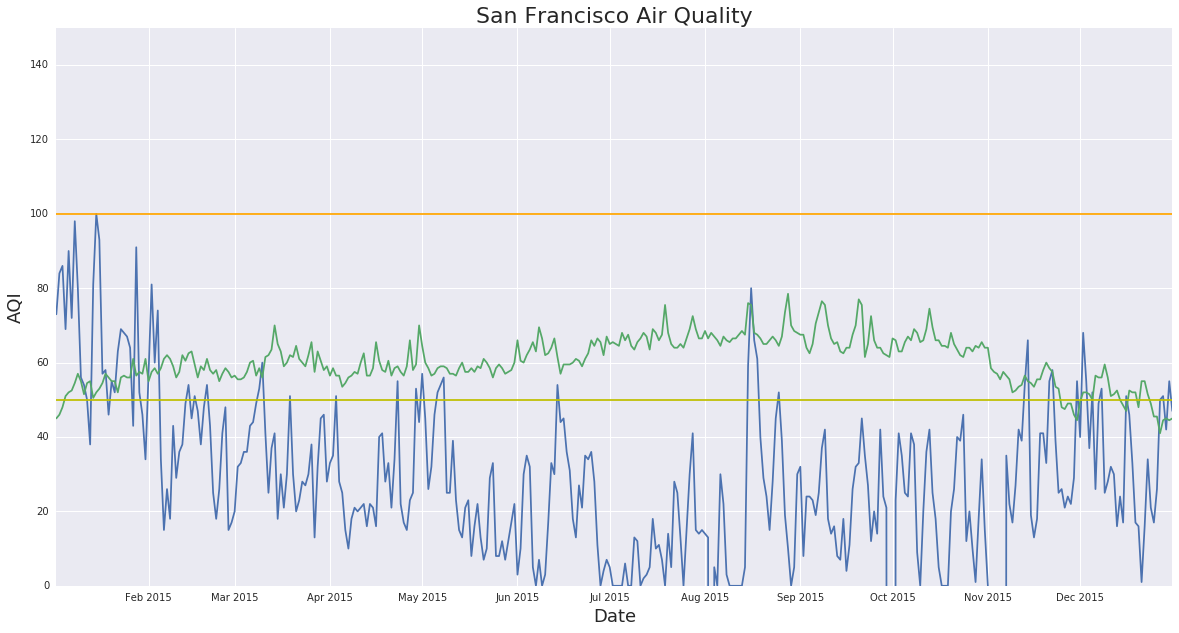

In [264]:
aq2015 = np.array(df)
aq2015.shape
plt.figure(figsize=(20,10))
plt.plot(aq2015[:,0], aq2015[:,2])
plt.plot(aq2015[:,0], aq2015[:,3])
plt.title("San Francisco Air Quality", fontsize=22)
plt.xlabel('Date', fontsize=18)
plt.ylabel('AQI', fontsize=18)
plt.ylim((0,150))
plt.axhline(y=50, label='Moderate', color='y')
plt.axhline(y=100, label='Unhealthy for sensitive groups', color='#FFA500')

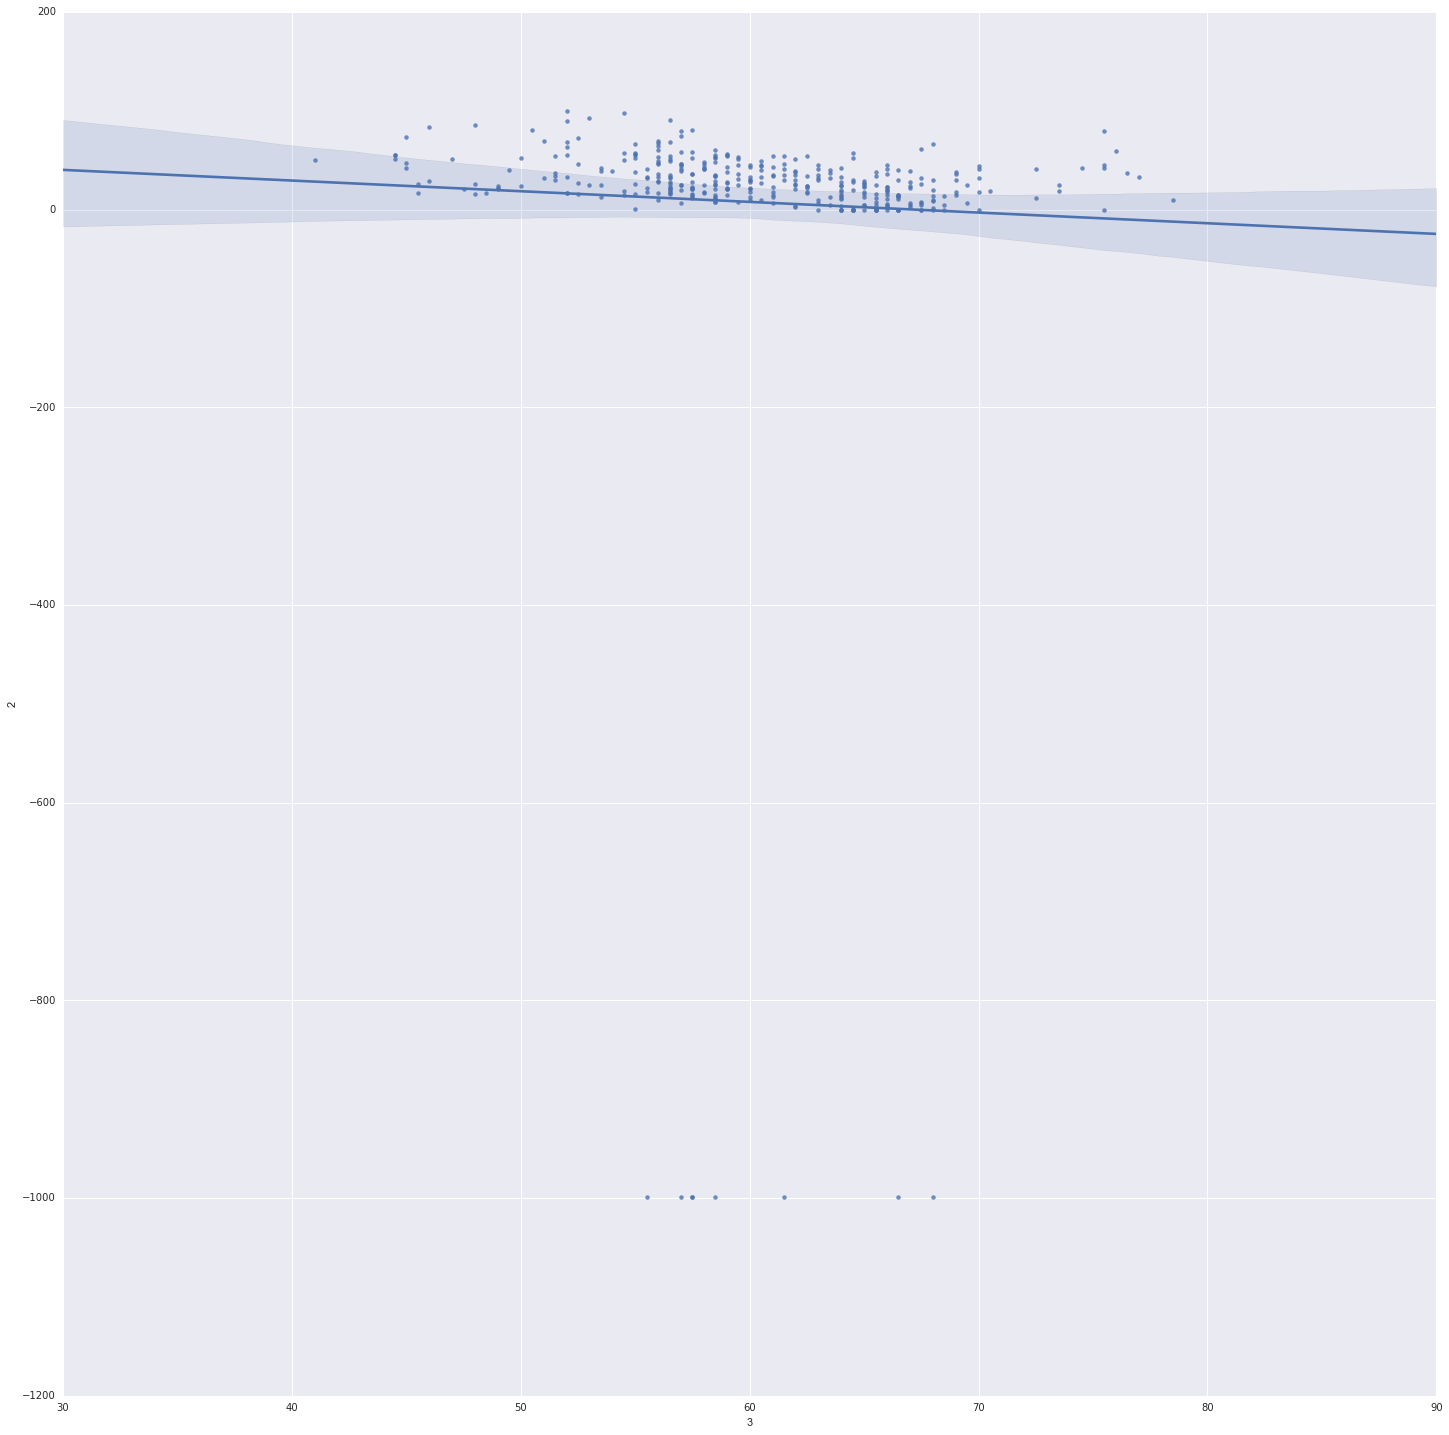

In [265]:
import seaborn as sns
sns.pairplot(df, x_vars=3, y_vars=2, size=20, kind='reg')

<b>Clean the data</b><br>
Missing values were denoted by -999. Eliminate those and redraw.

In [266]:
startdate=changetime('2015-01-01T00:00:00')
enddate=changetime('2015-12-31T23:59:59')
q="""
    select * from {table_name} where measurementDate > {t1} and measurementDate < {t2} and aqi!=-999
"""
query=q.format(table_name=table_name_sf, t1=startdate, t2=enddate)
#print (query)
ds=client.ts_query(table_name_sf, query)

df=pd.DataFrame(ds.rows)
print (df.head())
print (df.describe())

           0     1   2     3
0 2015-01-02  22.6  73  45.0
1 2015-01-03  27.9  84  46.0
2 2015-01-04  28.8  86  48.0
3 2015-01-05  20.6  69  51.0
4 2015-01-06  30.5  90  52.0
                1           2           3
count  356.000000  356.000000  356.000000
mean     7.558146   29.915730   60.460674
std      6.246835   20.308152    6.475838
min     -3.500000    0.000000   41.000000
25%      3.675000   15.000000   56.500000
50%      6.350000   26.500000   60.000000
75%     10.100000   42.000000   65.500000
max     35.400000  100.000000   78.500000


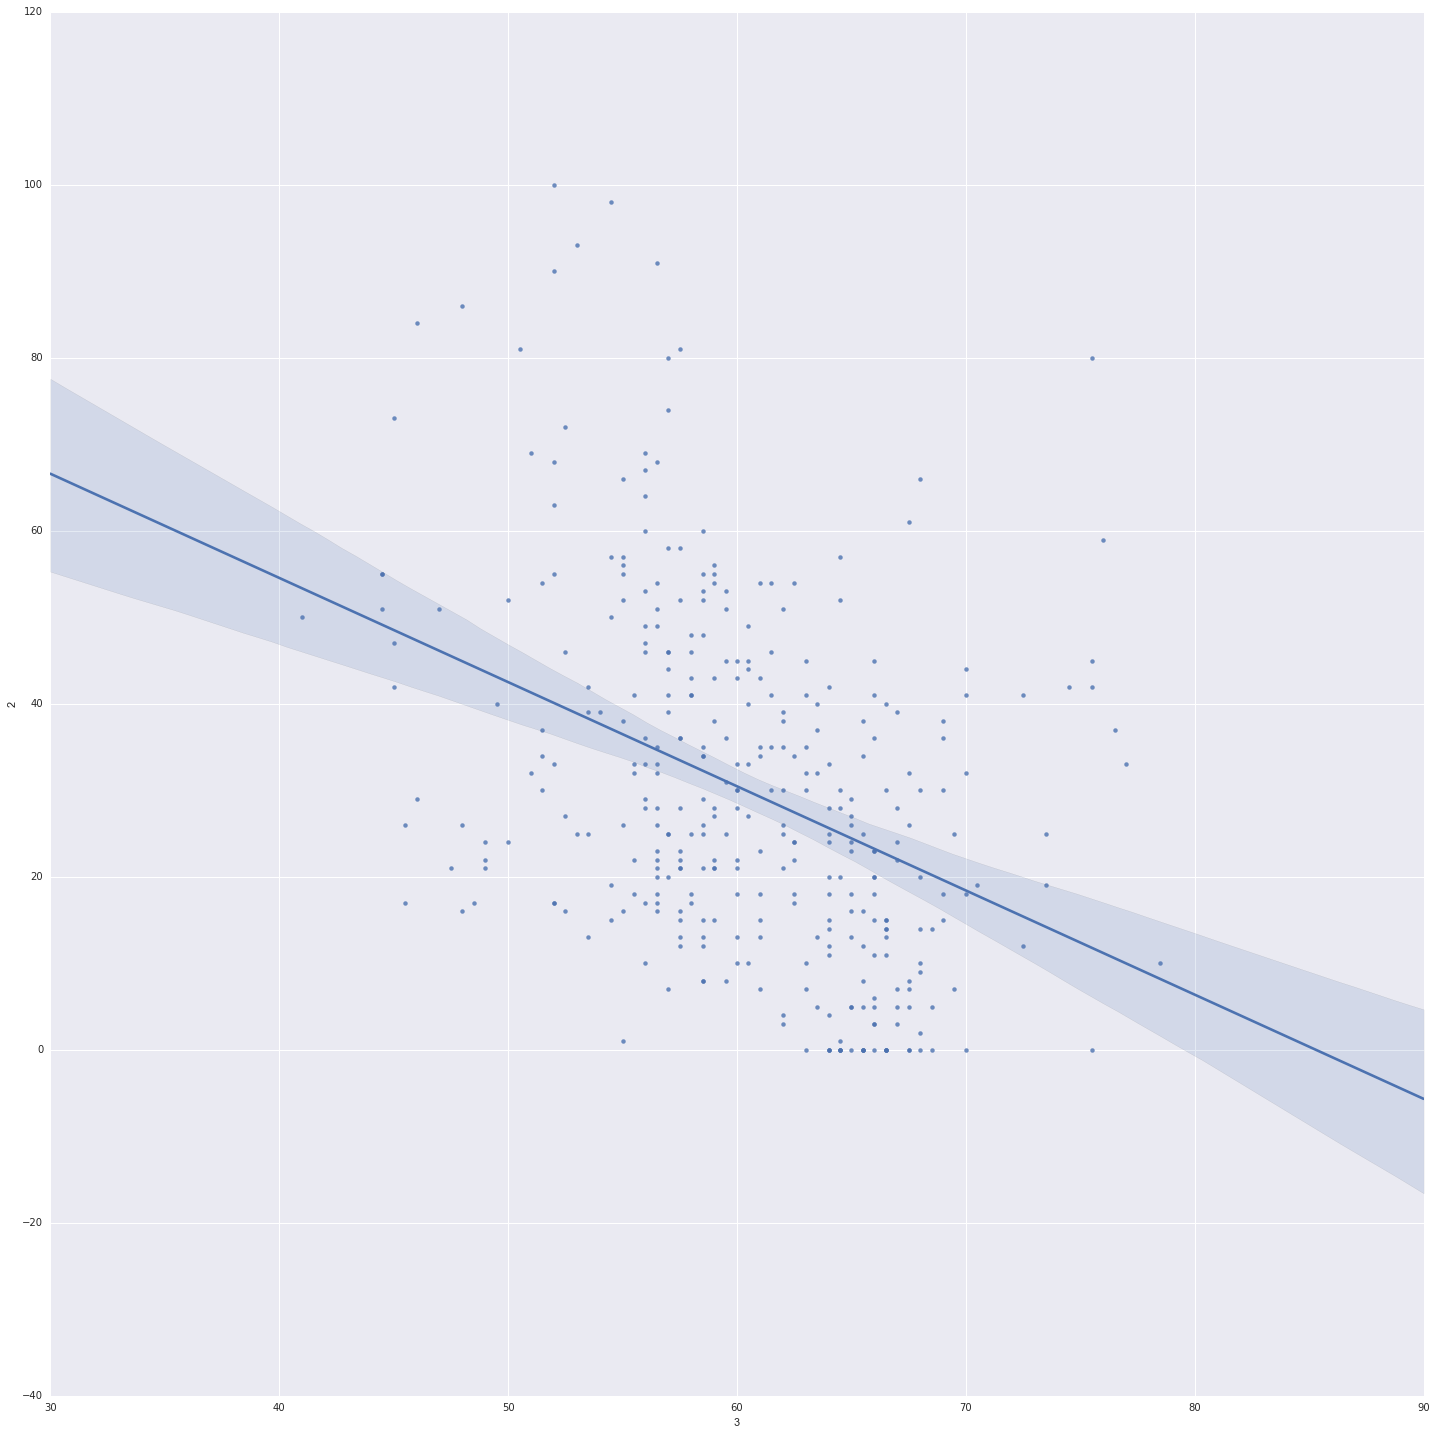

In [267]:
sns.pairplot(df, x_vars=3, y_vars=2, size=20, kind='reg')

<b>Whats next?</b>
There are other factors besides temperature that affect PM. Harvard university has done a study that examines correlations between fine particulate matter (PM2.5) and meteorological variables
in the United States. The study can be found here - http://acmg.seas.harvard.edu/publications/2010/Tai_2010.pdf <br>

Data can be evaluated continuously across the world by setting up a data pipeline from various data sources into a processing and visualization engine. One such project done examined London Air Quality data. 
<ul><li>Data was streamed from REST APIs to Kafka</li>
<li>Enriched using Spark Streaming</li>
<li>Consumed using Spring and write to Riak TS</li>
<li>Analyzed in Spark using Zeppelin Notebook</li>
<li>Inside a Mesos cluster</li>

<img src="files/data/LAQDemoArch.png">